In [2]:
from google.colab import files
uploaded = files.upload()   # choose cleaned_attendance.csv, tasks.csv, employees.csv


Saving cleaned_attendance.csv to cleaned_attendance.csv
Saving employees.csv to employees.csv
Saving tasks.csv to tasks.csv


In [4]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null


!wget -q https://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz
!tar xf spark-3.4.1-bin-hadoop3.tgz
!pip install -q findspark pyspark

# Step 3: Set environment variables
import os, findspark
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"
findspark.init()

# Step 4: Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("EmployeeAttendanceETL").getOrCreate()

print("Spark version:", spark.version)


Spark version: 3.4.1


In [5]:
# Load the uploaded CSVs into Spark DataFrames
attendance_df = spark.read.option("header", "true").option("inferSchema", "true").csv("/content/cleaned_attendance.csv")
tasks_df = spark.read.option("header", "true").option("inferSchema", "true").csv("/content/tasks.csv")
employees_df = spark.read.option("header", "true").option("inferSchema", "true").csv("/content/employees.csv")

print("Attendance Data:")
attendance_df.show(5)

print("Tasks Data:")
tasks_df.show(5)

print("Employees Data:")
employees_df.show(5)


Attendance Data:
+-----------+----------+-------------------+-------------------+-------------------+-------------------+-----------------+--------+---------------+---------------+-------------------+
|employee_id|      date|           clock_in|          clock_out|      clock_in_full|     clock_out_full|       work_hours|    name|department_name|tasks_completed| productivity_score|
+-----------+----------+-------------------+-------------------+-------------------+-------------------+-----------------+--------+---------------+---------------+-------------------+
|          1|2025-07-20|2025-08-17 09:00:00|2025-08-17 17:00:00|2025-07-20 09:00:00|2025-07-20 17:00:00|              8.0|Rishitha|             HR|              1|              0.125|
|          1|2025-07-21|2025-08-17 09:15:00|2025-08-17 17:05:00|2025-07-21 09:15:00|2025-07-21 17:05:00|7.833333333333333|Rishitha|             HR|              1|0.12765957446808512|
|          2|2025-07-21|2025-08-17 09:30:00|2025-08-17 16:50:00

In [7]:
# Join attendance + tasks
attendance_task_df = attendance_df.join(tasks_df, on="employee_id", how="left")

# Join with employees to bring Department column
full_df = attendance_task_df.join(employees_df, on="employee_id", how="left")

full_df.show(5)

+-----------+----------+-------------------+-------------------+-------------------+-------------------+-----------------+--------+---------------+---------------+-------------------+------------------+-----------+-------------+--------------+--------+---------------+
|employee_id|      date|           clock_in|          clock_out|      clock_in_full|     clock_out_full|       work_hours|    name|department_name|tasks_completed| productivity_score|         task_name|task_status|assigned_date|completed_date|    name|department_name|
+-----------+----------+-------------------+-------------------+-------------------+-------------------+-----------------+--------+---------------+---------------+-------------------+------------------+-----------+-------------+--------------+--------+---------------+
|          1|2025-07-20|2025-08-17 09:00:00|2025-08-17 17:00:00|2025-07-20 09:00:00|2025-07-20 17:00:00|              8.0|Rishitha|             HR|              1|              0.125|    Prepar

In [15]:
from pyspark.sql.functions import col, avg, count, when, round

# Drop the duplicate 'name' and 'department_name' columns from employees_df before the join
employees_df_cleaned = employees_df.drop("name", "department_name")

# Re-join attendance_task_df with the cleaned employees_df
full_df_cleaned = attendance_task_df.join(employees_df_cleaned, on="employee_id", how="left")

department_kpis = (
    full_df_cleaned.groupBy("department_name")
    .agg(
        round(avg("work_hours"),2).alias("Avg_WorkHours"),
        round(avg("tasks_completed"),2).alias("Avg_TasksCompleted"),
        round(avg("productivity_score"),2).alias("Avg_Productivity"),
        count(when(col("work_hours") == 0, 1)).alias("Absenteeism_Count")
    )
    .orderBy("department_name")
)

department_kpis.show(truncate=False)

# Save the department_kpis DataFrame to a single CSV file
department_kpis.coalesce(1).write.option("header", "true").mode("overwrite").csv("/content/department_kpis.csv")

+---------------+-------------+------------------+----------------+-----------------+
|department_name|Avg_WorkHours|Avg_TasksCompleted|Avg_Productivity|Absenteeism_Count|
+---------------+-------------+------------------+----------------+-----------------+
|Finance        |8.33         |1.0               |0.12            |0                |
|HR             |7.9          |1.0               |0.13            |0                |
|IT             |7.65         |1.0               |0.13            |0                |
|Marketing      |8.33         |1.0               |0.12            |0                |
|Sales          |7.17         |1.0               |0.14            |0                |
+---------------+-------------+------------------+----------------+-----------------+



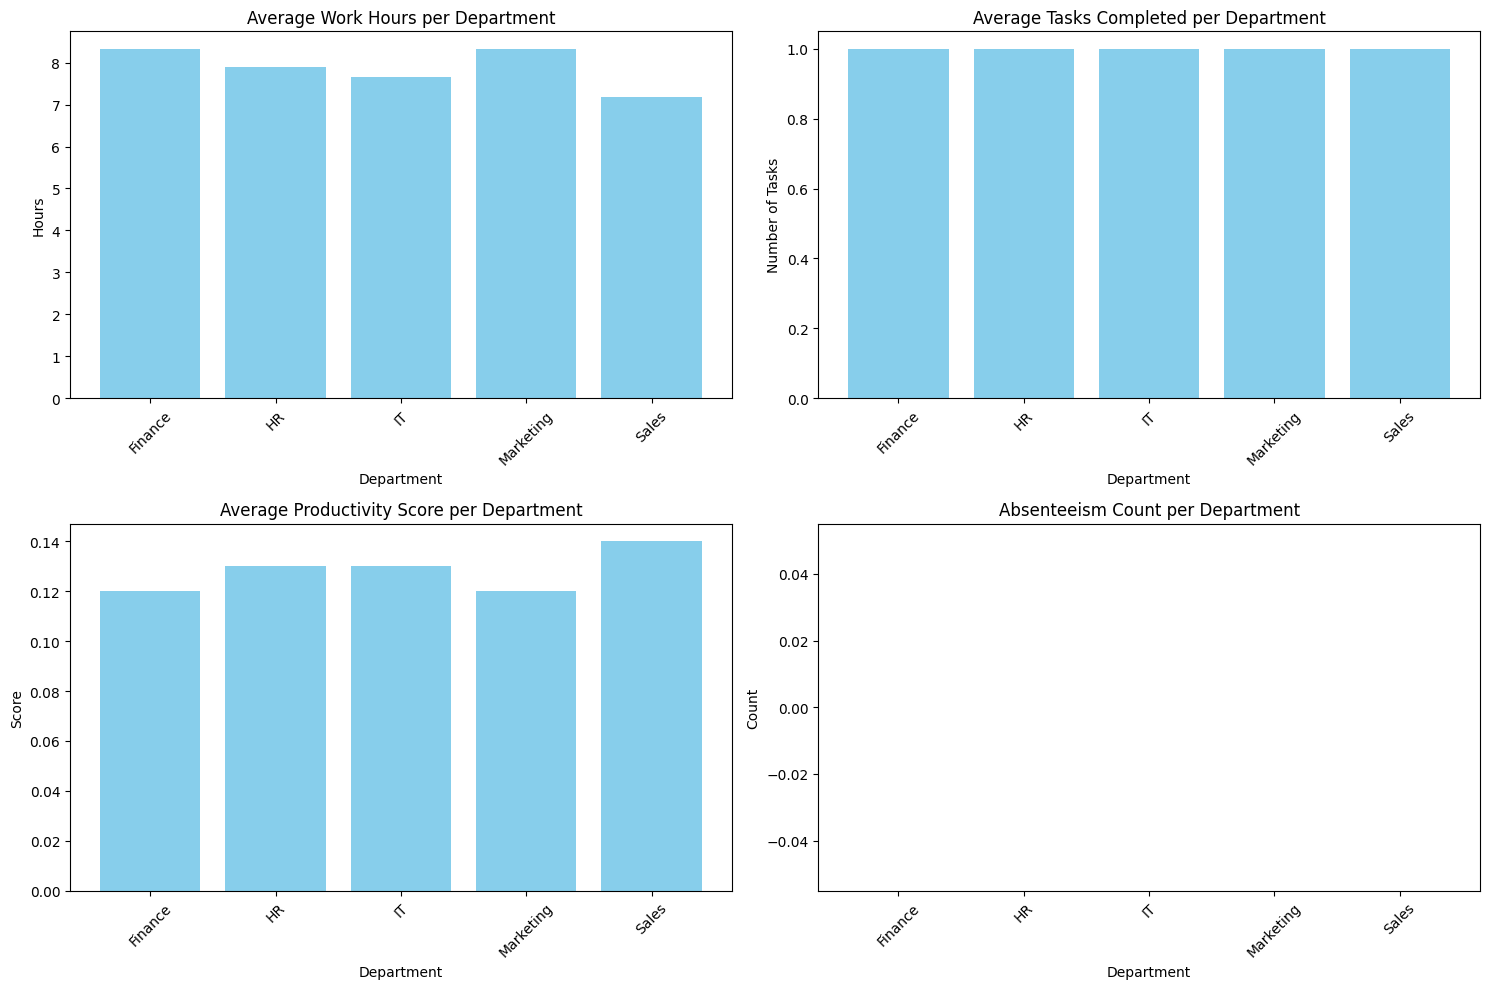

In [18]:
import matplotlib.pyplot as plt

# 1. Convert the department_kpis Spark DataFrame to a Pandas DataFrame.
department_kpis_pd = department_kpis.toPandas()

# 3. Create a figure with multiple subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = axes.flatten()  # Flatten the 2x2 array of axes for easy iteration

kpis = ['Avg_WorkHours', 'Avg_TasksCompleted', 'Avg_Productivity', 'Absenteeism_Count']
titles = ['Average Work Hours per Department', 'Average Tasks Completed per Department',
          'Average Productivity Score per Department', 'Absenteeism Count per Department']
y_labels = ['Hours', 'Number of Tasks', 'Score', 'Count']

# 4. For each subplot, create a bar chart
for i, kpi in enumerate(kpis):
    axes[i].bar(department_kpis_pd['department_name'], department_kpis_pd[kpi], color='skyblue')
    # 5. Set appropriate titles and labels
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Department')
    axes[i].set_ylabel(y_labels[i])
    axes[i].tick_params(axis='x', rotation=45) # Rotate x-axis labels for better readability

# 6. Adjust the layout of the subplots
plt.tight_layout()

# 7. Display the plots.
plt.show()